<a href="https://colab.research.google.com/github/LaZzyMan/Notebook/blob/master/DataPreview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

数据处理过程：
缓冲区50m
落在多个地块内的轨迹的权重设置为1/起点地块数*终点地块数
只保留起点和终点均在区域内的轨迹（删除3w条）
按照出入度筛选区域
再次筛选位于目标区域内的轨迹

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import psycopg2
from shapely.geometry import MultiPolygon, Point
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, scale
from sklearn.cluster import Birch, KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn import metrics

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['font.sans-serif']=['SimHei']

sns.set(style="darkgrid")
sns.set_context('talk')

In [ ]:
conn = psycopg2.connect(database='taxidata', user='lazzy',
                        password='7325891325', host='202.114.121.252', 
                        port='5432')
unit = gpd.read_postgis(sql='select * from landuse.cab_unit_filtered',
                       con=conn, geom_col='geometry', index_col='id')
mat = np.load('data/export/matrix.npy')

In [ ]:
conn = psycopg2.connect(database='taxidata', user='lazzy',
                        password='7325891325', host='202.114.121.252', 
                        port='5432')

In [ ]:
mat_30 = np.zeros((48, mat.shape[1], mat.shape[2]), dtype=np.float16)
for i in range(mat.shape[1]):
    for j in range(mat.shape[2]):
        for k in range(48):
            mat_30[k, i, j] = mat[2 * k, i, j] + mat[2 * k + 1, i, j]
np.save('data/export/matrix_30.npy', mat_30)

In [ ]:
mat_60 = np.zeros((24, mat.shape[1], mat.shape[2]), dtype=np.float16)
for i in range(mat.shape[1]):
    for j in range(mat.shape[2]):
        for k in range(24):
            mat_60[k, i, j] = mat[4 * k, i, j] + mat[4 * k + 1, i, j] + mat[4 * k + 2, i, j] + mat[4 * k + 3, i, j]
np.save('data/export/matrix_60.npy', mat_60)

KeyboardInterrupt: 

In [ ]:
# 15min
mat = np.load('data/export/matrix.npy')
x_label = []
for i in range(24):
    for j in ['00', '15', '30', '45']:
        x_label.append('%02d:%s' % (i, j))

In [ ]:
# 30min
mat = np.load('data/export/matrix_30.npy')
x_label = []
for i in range(24):
    for j in ['00', '30']:
        x_label.append('%02d:%s' % (i, j))

In [ ]:
# 1h
mat = np.load('data/export/matrix_60.npy')
x_label = []
for i in range(24):
    for j in ['00']:
        x_label.append('%02d:%s' % (i, j))

In [ ]:
unit = gpd.read_postgis(sql='select id, raw_id, class, class_code, geometry from landuse.cab_unit_filtered_reindex',
                       con=conn, geom_col='geometry', index_col='id')
class_list = list(unit['class_code'].unique())
unit['class_id'] = unit.apply(lambda x: class_list.index(x['class_code']), axis=1)
unit

,raw_id,class,class_code,geometry,class_id
id,,,,,
1,505,商业服务业用地,C,(POLYGON ((114.0589416452287 22.54456070464853...,0
2,6251,公共管理与服务用地,GIC,(POLYGON ((113.9112086720426 22.48682022622705...,1
3,6303,公共管理与服务用地,GIC,(POLYGON ((113.9259077501718 22.50001384893038...,1
4,506,商业服务业用地,C,(POLYGON ((114.0869380281112 22.54456412416876...,0
5,507,商业服务业用地,C,(POLYGON ((113.9355259050363 22.54543142006697...,0
6,508,商业服务业用地,C,(POLYGON ((114.1121339051394 22.54468802258064...,0
7,509,商业服务业用地,C,(POLYGON ((114.0437054571827 22.54505195036064...,0
8,510,商业服务业用地,C,(POLYGON ((114.1134921797225 22.54456665888466...,0
9,511,商业服务业用地,C,(POLYGON ((114.1026912100367 22.54554529650902...,0


# Overview

## 类型及分布

土地利用类型数据共包含了8类土地利用类型

In [ ]:
unit[['class_id', 'class_code', 'class']].drop_duplicates()

,class_id,class_code,class
id,,,
1,0,C,商业服务业用地
2,1,GIC,公共管理与服务用地
10,2,G,绿地与广场
44,3,M,工业用地
150,4,R,居住用地
5776,5,U,市政公用设施用地
712,6,W,物流仓储用地
992,7,SS,机场码头用地


各类型区域数量分布，其中机场码头类型是手动选择得到的，因此数量非常少，筛选之后只剩下8个

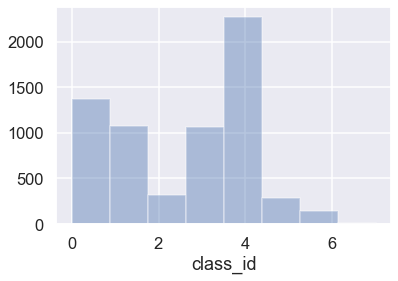

In [ ]:
sns.distplot(unit['class_id'], kde=False, rug=False, bins=8)

各区域节点的度分布情况

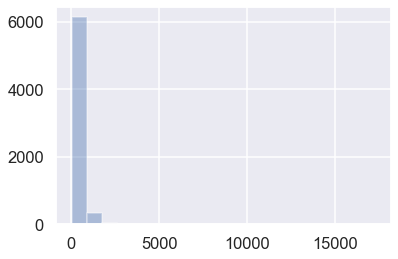

In [ ]:
out_flow_sum = mat.sum(axis=(0, 1))
in_flow_sum = mat.sum(axis=(0, 2))
max(in_flow_sum)
max(out_flow_sum)
min(in_flow_sum)
min(out_flow_sum)
sns.distplot(in_flow_sum+out_flow_sum, kde=False, rug=False, bins=20)

## 轨迹数据分布

将两天的总流量数据划分到15min间隔，得到的流量-时间曲线基本符合出租车活动规律

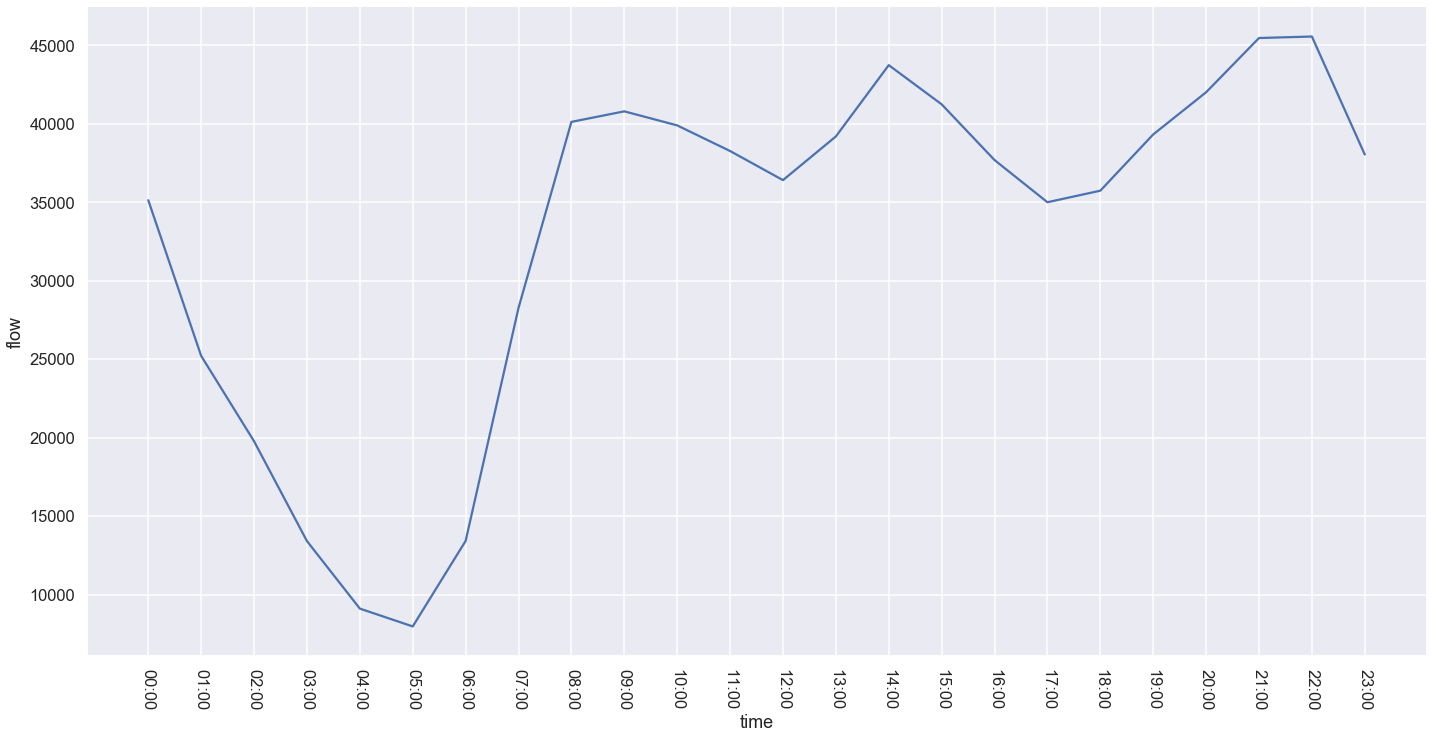

In [ ]:
flow_sum = mat.sum(axis=(1, 2))
ax = sns.relplot(x='time', y='flow', kind='line', data=pd.DataFrame(dict(time=x_label, flow=flow_sum)), aspect=2, height=10)
ax.set_xticklabels(rotation=-90)

## 区域时间-流量曲线

选取一个区域绘制其出度、入度和总流量分布曲线，可以看见曲线并不是很平滑（大概是因为只用了两天的数据，平均15min的流量数只有个位数）

In [ ]:
def show_flow_curve(unit_id): 
    out_flow = mat[:, unit_id, :].sum(axis=1)
    in_flow = mat[:, :, unit_id].sum(axis=1)
    flow = in_flow + out_flow
    dfs = []
    dfs.append(pd.DataFrame(dict(time=x_label, value=in_flow, type=['in_flow' for _ in x_label])))
    dfs.append(pd.DataFrame(dict(time=x_label, value=out_flow, type=['out_flow' for _ in x_label])))
    dfs.append(pd.DataFrame(dict(time=x_label, value=flow, type=['flow' for _ in x_label])))
    ax = sns.relplot(x='time', y='value', kind='line', hue='type', data=pd.concat(dfs, axis=0), aspect=2, height=10)
    ax.set_xticklabels(rotation=-90)

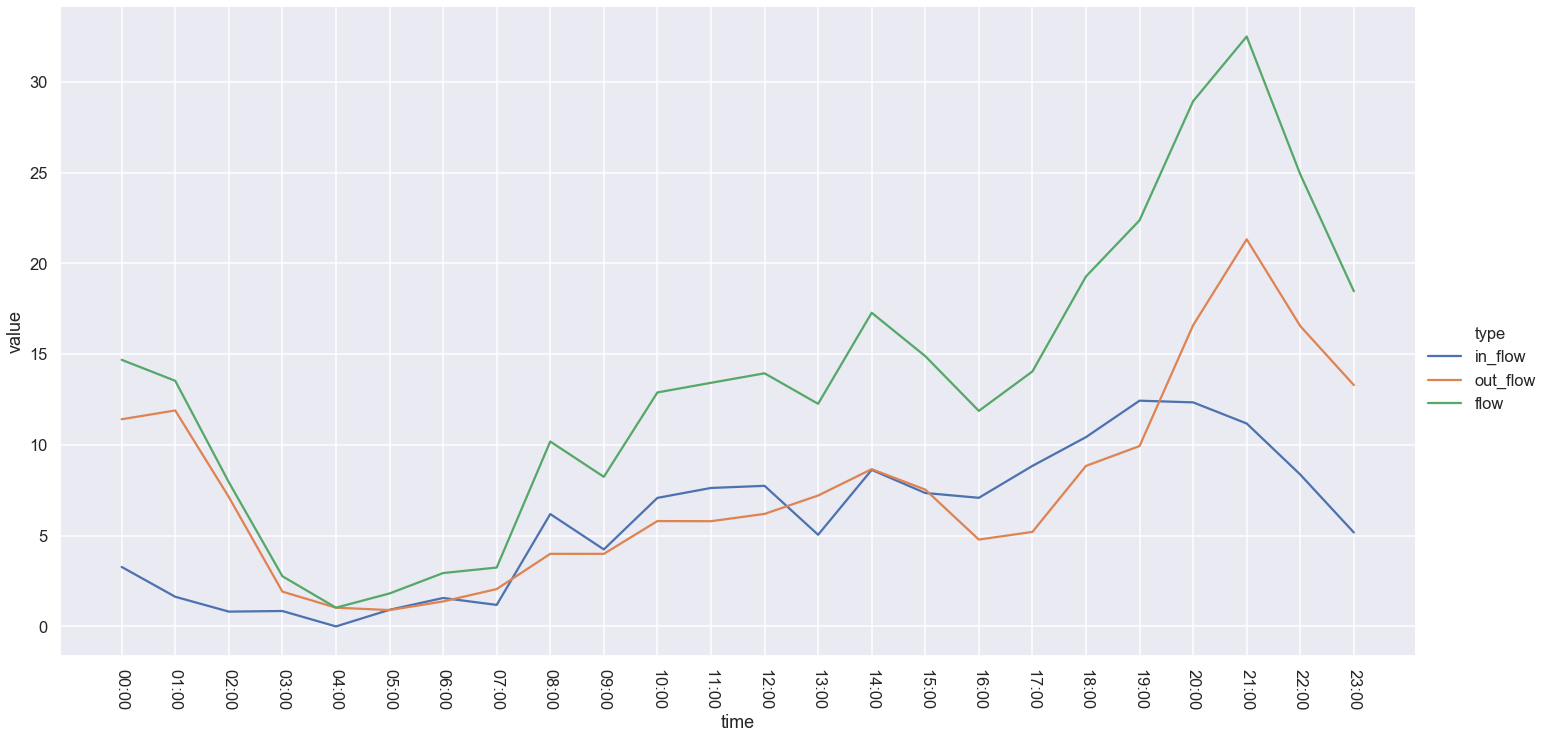

In [ ]:
show_flow_curve(unit_id=1)

## 标准化

分别对各区域的出度、入度、总流量曲线进行z-score标准化，重新绘制曲线

In [ ]:
def show_norm_flow_curve(unit_id): 
    out_flow = mat[:, unit_id, :].sum(axis=1)
    in_flow = mat[:, :, unit_id].sum(axis=1)
    flow = in_flow + out_flow
    out_flow = scale(out_flow)
    in_flow = scale(in_flow)
    flow = scale(flow)
    dfs = []
    dfs.append(pd.DataFrame(dict(time=x_label, value=in_flow, type=['in_flow' for _ in x_label])))
    dfs.append(pd.DataFrame(dict(time=x_label, value=out_flow, type=['out_flow' for _ in x_label])))
    dfs.append(pd.DataFrame(dict(time=x_label, value=flow, type=['flow' for _ in x_label])))
    ax = sns.relplot(x='time', y='value', kind='line', hue='type', data=pd.concat(dfs, axis=0), aspect=2, height=10)
    ax.set_xticklabels(rotation=-90)

d:\program files\python37\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
d:\program files\python37\lib\site-packages\sklearn\preprocessing\data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
d:\program files\python37\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
d:\program files\python37\lib\site-packages\sklearn\preprocessing\data.py:189: UserWarning: Numer

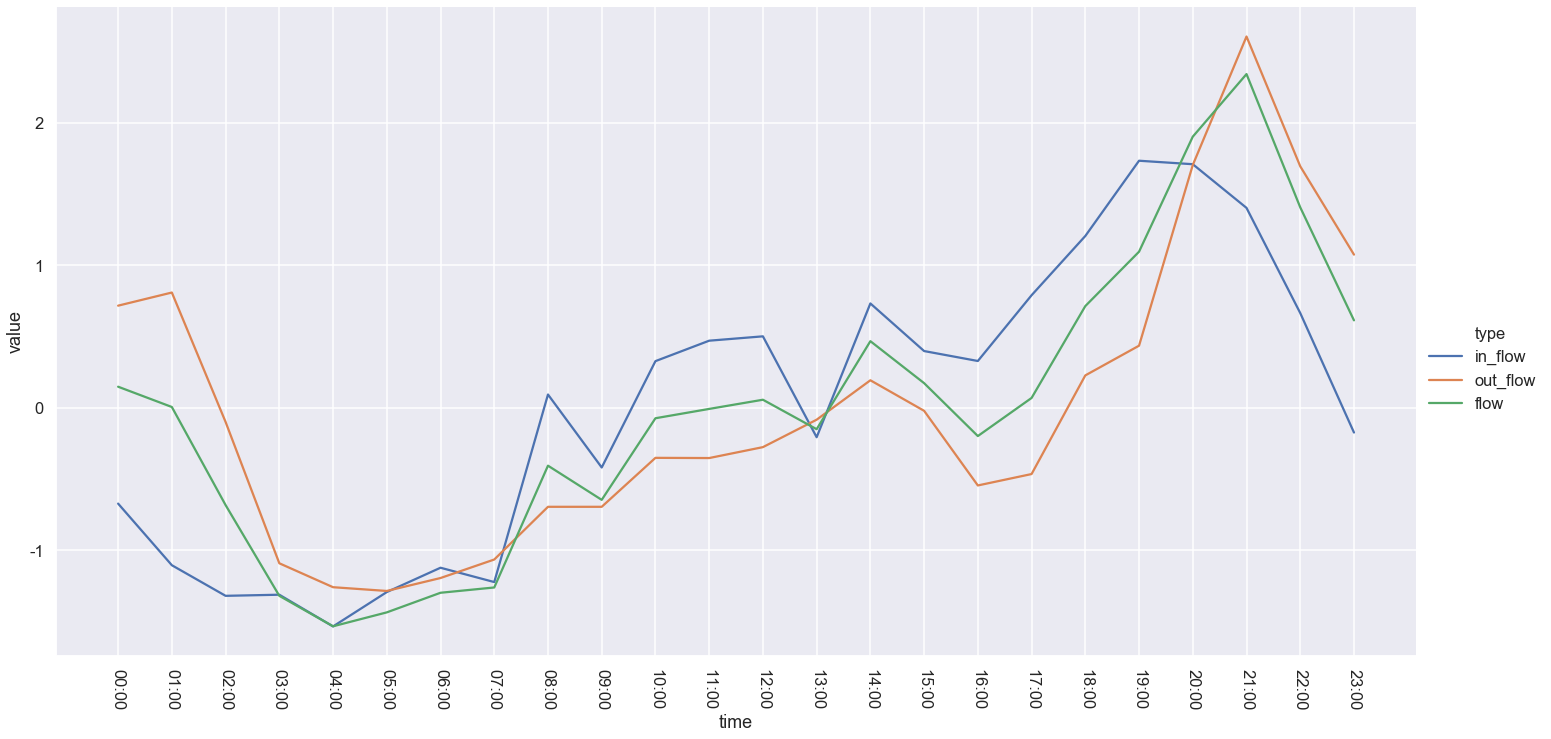

In [ ]:
show_norm_flow_curve(unit_id=1)

In [ ]:
in_flow = mat.sum(axis=2)
out_flow = mat.sum(axis=1)
in_out_flow = np.concatenate((in_flow, out_flow), axis=0)
in_flow_scaler = StandardScaler().fit(in_flow)
out_flow_scaler = StandardScaler().fit(out_flow)
flow_scaler = StandardScaler().fit(in_flow + out_flow)
source_link_scaler = StandardScaler().fit(in_flow - out_flow)
in_out_flow_scaler = StandardScaler().fit(in_out_flow)
in_flow_norm = in_flow_scaler.transform(in_flow)
out_flow_norm = out_flow_scaler.transform(out_flow)
flow_norm = flow_scaler.transform(in_flow + out_flow)
source_link = source_link_scaler.transform(in_flow - out_flow)
in_out_flow_norm = in_out_flow_scaler.transform(in_out_flow)

d:\program files\python37\lib\site-packages\numpy\lib\nanfunctions.py:1508: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
d:\program files\python37\lib\site-packages\numpy\lib\nanfunctions.py:1508: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
d:\program files\python37\lib\site-packages\numpy\lib\nanfunctions.py:1508: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
d:\program files\python37\lib\site-packages\numpy\lib\nanfunctions.py:1508: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
d:\program files\python37\lib\site-packages\numpy\lib\nanfunctions.py:1508: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


In [ ]:
flow_df = []
for index, row in tqdm_notebook(unit.iterrows()):
    flow_df.append(pd.DataFrame(dict(time=x_label, flow=flow_norm[:, index - 1], unit=[index for _ in x_label], type=[row['class'] for _ in x_label])))
flow_df = pd.concat(flow_df, axis=0)

## 对比不同类型区域曲线

在每种类型的区域中随机选取5个作为样本，绘制和对比其时间-流量曲线，可以发现：同种类型区域的曲线存在一定的差异，一些不同类型区域曲线存在着较为明显的差异。

In [ ]:
unit_sample = []
for c in unit['class_code'].unique():
    c_df = unit[unit['class_code']==c]
    sample = c_df.sample(n=5)
    unit_sample.append(sample)
unit_sample = pd.concat(unit_sample, axis=0)

,raw_id,class,class_code,geometry
id,,,,
879,1265,商业服务业用地,C,(POLYGON ((114.1138659563291 22.58545479862516...
392,745,商业服务业用地,C,(POLYGON ((114.1473810068846 22.55452661113783...
6465,3090,商业服务业用地,C,(POLYGON ((114.0441778207568 22.69801699885511...
1112,1572,商业服务业用地,C,(POLYGON ((114.0357815021602 22.60519207660222...
6091,108,商业服务业用地,C,(POLYGON ((113.8956618464867 22.50684204154606...
1948,6810,公共管理与服务用地,GIC,"(POLYGON ((114.1295373541427 22.5466343511919,..."
1918,6744,公共管理与服务用地,GIC,(POLYGON ((114.0854824497705 22.54371209751126...
2213,7372,公共管理与服务用地,GIC,(POLYGON ((114.0554037256261 22.56831644410685...
2,6251,公共管理与服务用地,GIC,(POLYGON ((113.9112086720426 22.48682022622705...


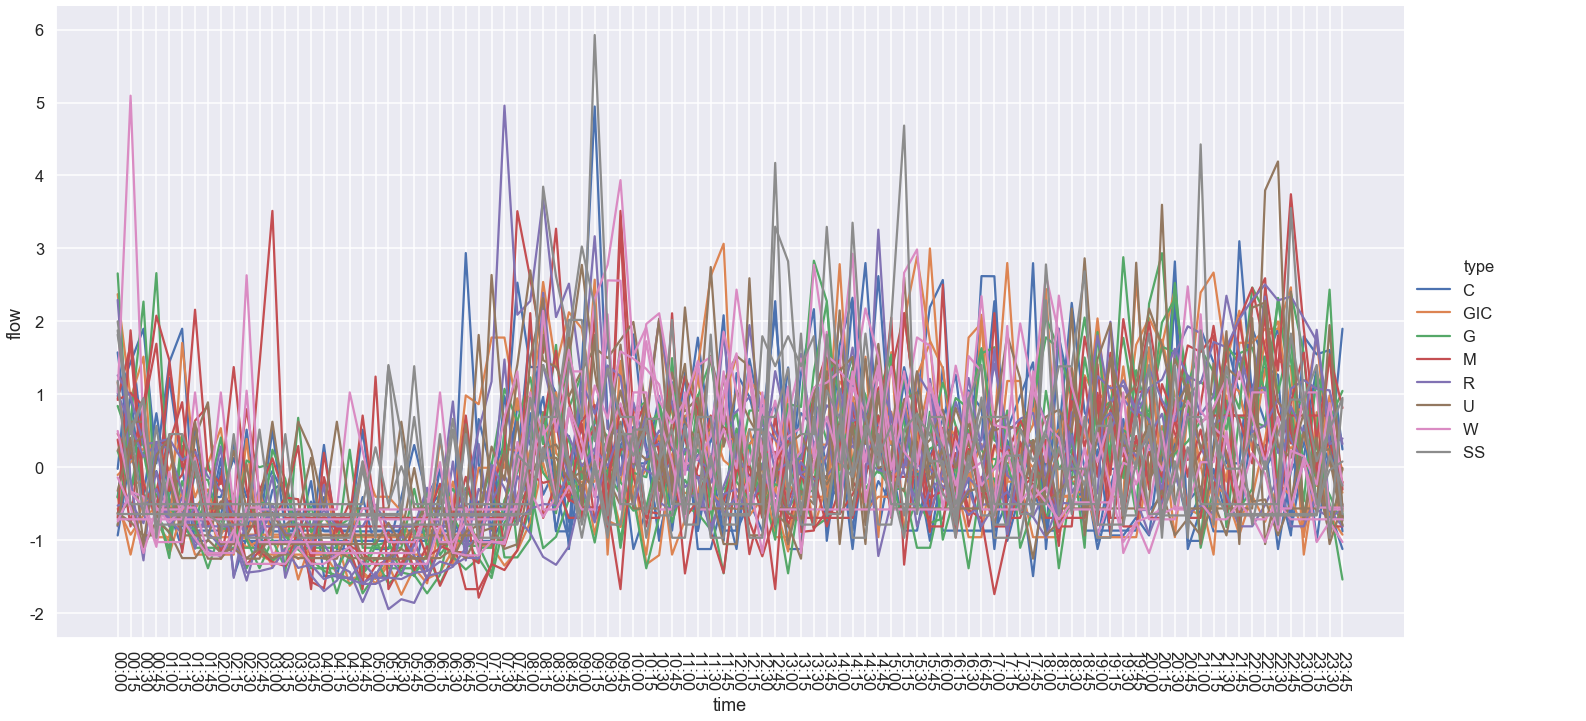

In [ ]:
flow_sample_df = []
for index, row in tqdm_notebook(unit_sample.iterrows()):
    flow_sample_df.append(pd.DataFrame(dict(time=x_label, flow=flow_norm[:, index - 1], unit=[index for _ in x_label], type=[row['class_code'] for _ in x_label])))
flow_sample_df = pd.concat(flow_sample_df, axis=0)
ax = sns.relplot(x='time', y='flow', kind='line', hue='type', units='unit', data=flow_sample_df, aspect=2, height=10, estimator=None)
ax.set_xticklabels(rotation=-90)

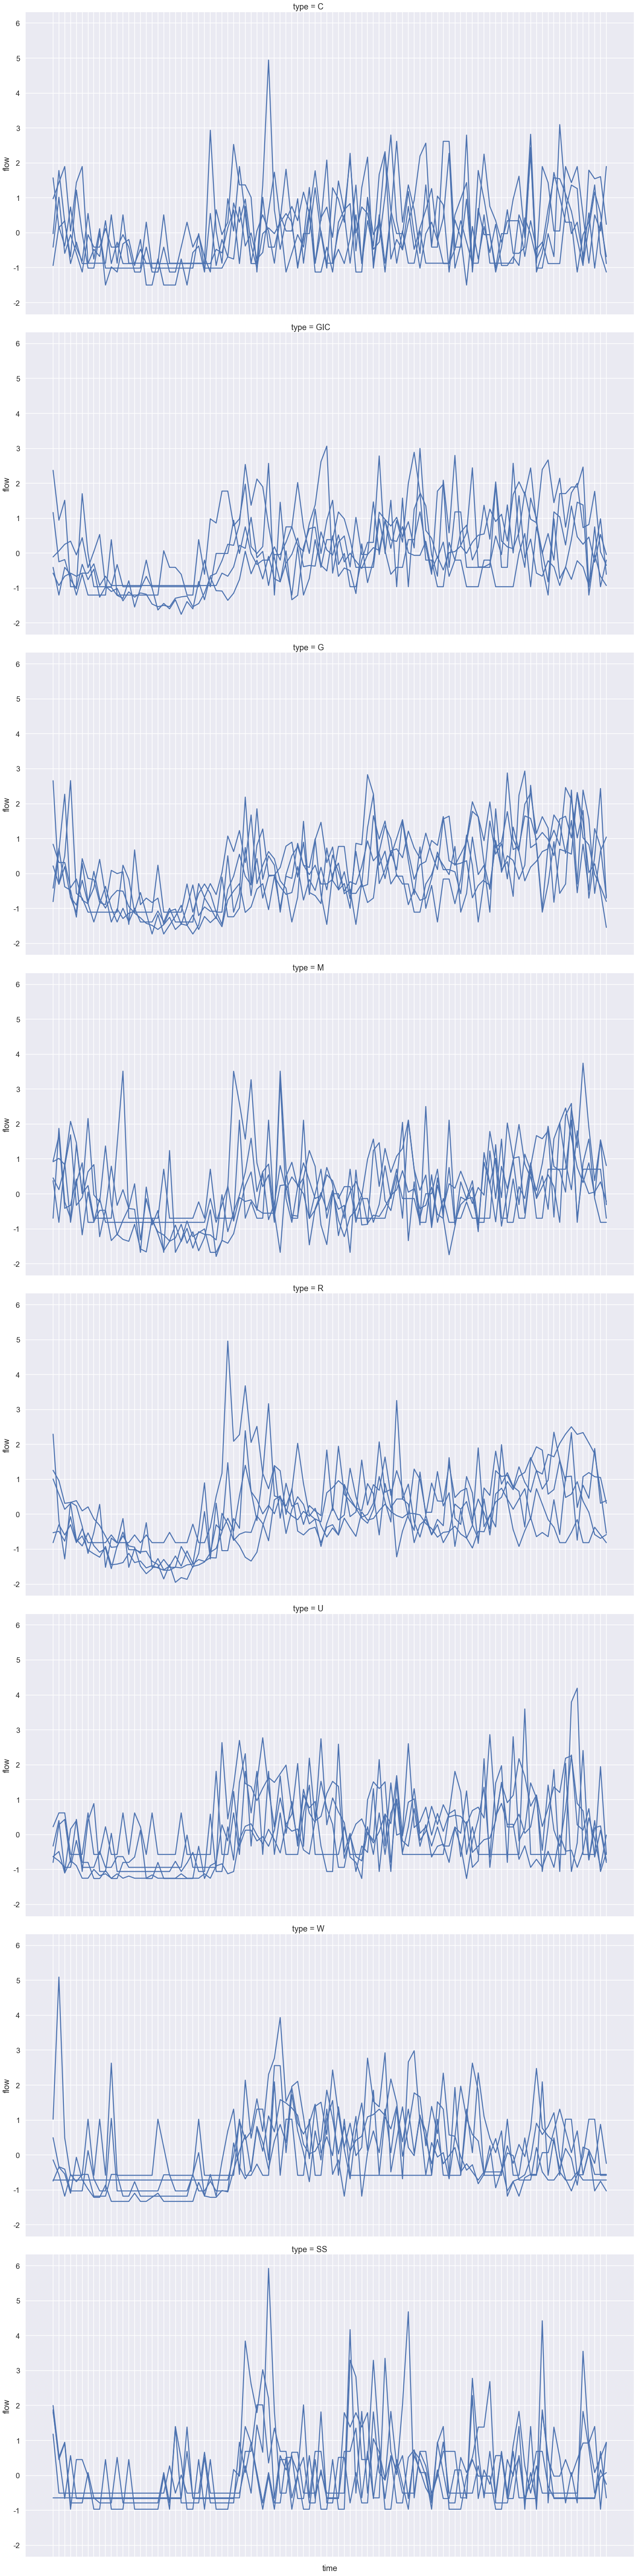

In [ ]:
ax = sns.relplot(x='time', y='flow', kind='line', row='type', units='unit', data=flow_sample_df, aspect=2, height=10, estimator=None)
ax.set_xticklabels(rotation=-90)

# 土地利用类型分类


利用k-means进行聚类：
首先综合使用Calinski Harabaz Score、SSE和Silhouette Score标准确定最优k值；
之后进行k-means聚类；
并利用rank指数和交互信息指数衡量得到的聚类结果和真实分类的符合程度。

分别使用总流量、出度-入度（source-link）和出度-入度（96*2个特征）作为聚类特征进行测试。

In [ ]:
  def k_select(data, k_min=2, k_max=20):
    chs = []
    sse = []
    scs = []
    for k in range(k_min, k_max + 1):
        estimator = KMeans(n_clusters=k, max_iter=100, n_init=10, init='k-means++')
        y_pred = estimator.fit_predict(data)
        chs.append(calinski_harabasz_score(data, y_pred))
        sse.append(estimator.inertia_)
        scs.append(silhouette_score(data, y_pred, metric='euclidean'))
    chs_df = pd.DataFrame(dict(k=[k for k in range(k_min, k_max + 1)], value=chs, type=['Calinski Harabaz Score' for _ in range(k_min, k_max + 1)]))
    sse_df = pd.DataFrame(dict(k=[k for k in range(k_min, k_max + 1)], value=sse, type=['SSE' for _ in range(k_min, k_max + 1)]))
    scs_df = pd.DataFrame(dict(k=[k for k in range(k_min, k_max + 1)], value=scs, type=['Silhouette Score' for _ in range(k_min, k_max + 1)]))
    return chs_df, sse_df, scs_df
    # sns.relplot(x='k', y='value', kind='line', row='type', data=pd.concat([chs_df, sse_df, scs_df], axis=0), aspect=2, height=8, estimator=None)

In [ ]:
def kmeans_result_analysis(data, k):
    y_true = np.array(unit['class_id'])
    estimator = KMeans(n_clusters=k, max_iter=100, n_init=10, init='k-means++')
    y_pred = estimator.fit_predict(data)
    ARI = metrics.adjusted_rand_score(y_true, y_pred)
    AMI = metrics.adjusted_mutual_info_score(y_true, y_pred)
    print('ARI: %f.\nAMI: %f.' % (ARI, AMI))
    return y_pred

## flow聚类

In [ ]:
chs_df, sse_df, scs_df = k_select(flow_norm.T)

sse得到的手肘状曲线的‘关节’处表示最优k值

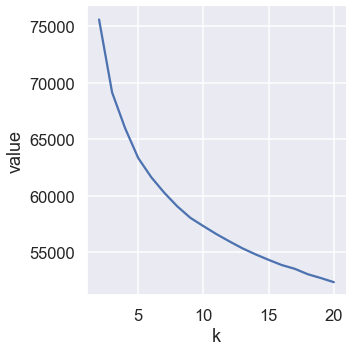

In [ ]:
sns.relplot(x='k', y='value', kind='line', data=sse_df)

边缘指数越大反映聚类结果越好，综合sse曲线选择k=8

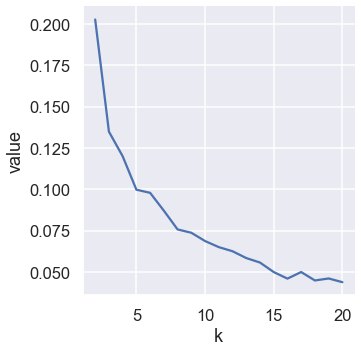

In [ ]:
sns.relplot(x='k', y='value', kind='line', data=scs_df)

ARI和AMI指数的范围均为[-1, 1]，反映了两个分类结果的相似程度（真值中属于同一类别的节点在预测之中依然属于同一类别）。
本结果和之后几个结果中评价指数均在0.01-0.02左右，可以判断聚类结果与真实结果有一定的重合，但是整体上效果较差。

分类结果在kepler上进行了绘制 https://kepler.gl/demo/map?mapUrl=https://dl.dropboxusercontent.com/s/rewm38dvmnwwn5v/keplergl_5aseff.json

In [ ]:
flow_pred = kmeans_result_analysis(flow_norm.T, 8)

d:\program files\python37\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


ARI: 0.009722.
AMI: 0.010850.


## source-link聚类

In [ ]:
sl_pred = kmeans_result_analysis(source_link.T, 8)

d:\program files\python37\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


ARI: 0.028705.
AMI: 0.020436.


## in_flow out_flow聚类

In [ ]:
io_pred = kmeans_result_analysis(in_out_flow_norm.T, 8)

d:\program files\python37\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


ARI: 0.017361.
AMI: 0.018565.


In [ ]:
unit['flow_pred'] = flow_pred
unit['sl_pred'] = sl_pred
unit['io_pred'] = io_pred
